In [1]:
from fastai2.vision.all import *
from faststyle import *

In [2]:
source = Path('/notebooks/storage/data/road_segmentation_ideal')

In [3]:
def get_items(source):
  'Remove missing labels'
  fns = get_image_files(source/'training/input') + get_image_files(source/'testing/input')
  fns_out = get_image_files(source/'labels').map(attrgetter('stem'))
  return fns.filter(lambda o: o.stem in fns_out)

In [4]:
def get_y(fn): return source/'labels'/fn.name

In [5]:
def MaskBlock2(codes=None):
  return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodes(codes=codes), batch_tfms=IntToFloatTensor(div_mask=255))

In [6]:
dblock = DataBlock((ImageBlock, MaskBlock2(['road'])), get_items=get_items, get_y=get_y,
                   splitter=GrandparentSplitter('training', 'testing'), item_tfms=[Resize(256)],
                   batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])
dls = dblock.dataloaders(source, bs=32); dls.c = 2

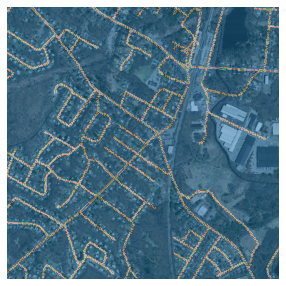

In [7]:
show_at(dls.train_ds, 0)

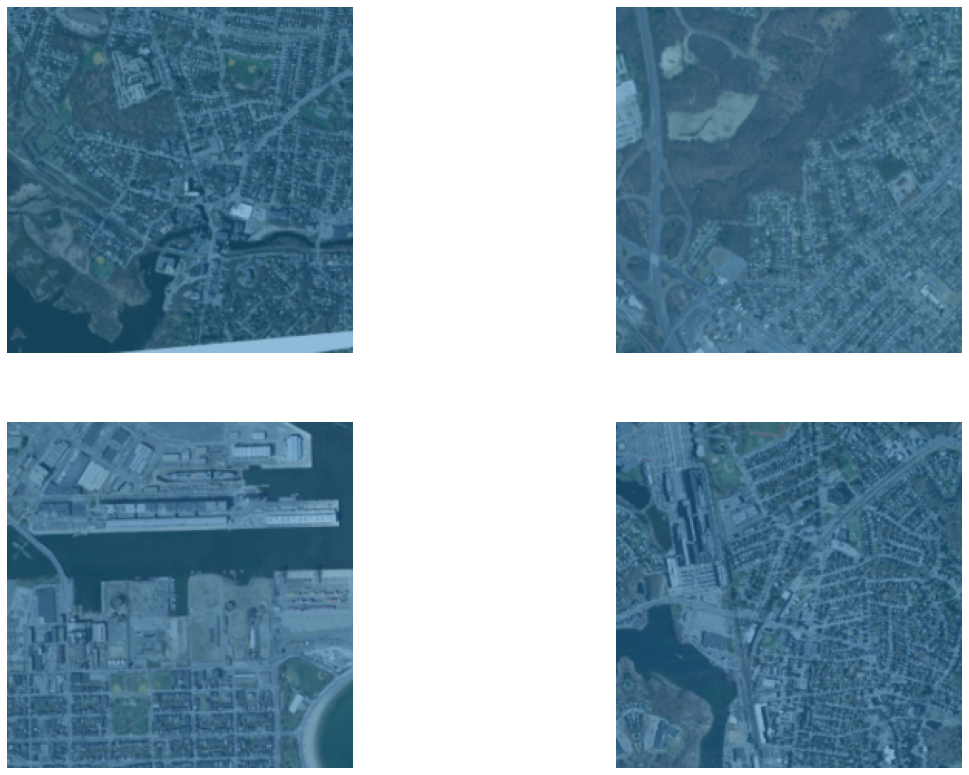

In [8]:
dls.show_batch(max_n=4, figsize=(20,14))

In [9]:
learn = unet_learner(dls, resnet18, metrics=partial(accuracy, axis=1))

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.17378008365631104)

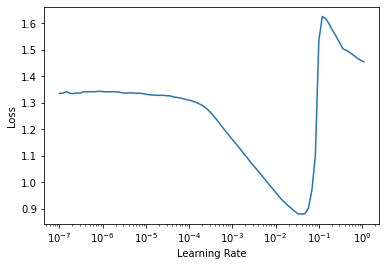

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(1, 3e-3, pct_start=.99)

epoch,train_loss,valid_loss,accuracy,time
0,0.724566,0.440943,0.811120,00:29


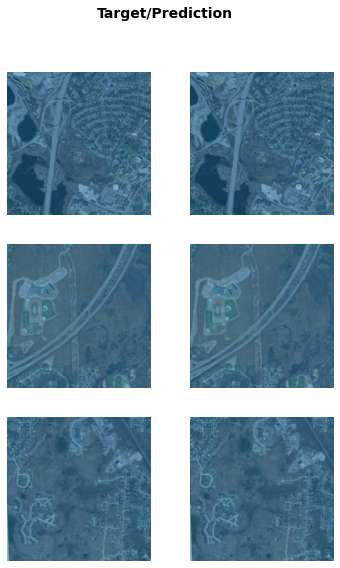

In [12]:
learn.show_results()